# Study of Image classification with modern MLP Mixer model and CKA

**Author:** [Arturo Flores](https://www.linkedin.com/in/afloresalv/)<br>
**Based on (MLP-MIXER):**  https://keras.io/examples/vision/mlp_image_classification/

# Setup for the MLP-Mixer Architecture

################################################################

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt 
from scipy.stats import norm
from matplotlib.ticker import FormatStrFormatter
import datetime
import pickle
# Files imported from the sleected GitHub https://cka-similarity.github.io/
from CKA_Google import *
import seaborn as sns 
import random
import matplotlib.pyplot as plt 

C:\Users\alach\AppData\Roaming\Python\Python38\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


# Experiment 1 : Understand Network Architecture

## Configure the hyperparameters

In [2]:
weight_decay = 0.0001
batch_size = 512 
num_epochs = 50
dropout_rate = 0.2
learning_rate = 0.005

## Selected Architecture: B/32

image_size = 224  # We'll resize input images to this size. Square
patch_size = 32  # Size of the patches to be extracted from the input images. Square
num_patches = (image_size // patch_size) ** 2  # Size of the data array, or sequence length (S)
embedding_dim = [384]  # Fixed Embedding Dimension
num_blocks = [8,12,24,32]

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")

now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d_%H-%M")


Image size: 224 X 224 = 50176
Patch size: 32 X 32 = 1024 
Patches per image: 49
Elements per patch (3 channels): 3072


## Prepare the data

In [3]:
#Dataset for training 

num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
#plt.imshow(x_train[1])

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Build a classification model

In [4]:
def build_classifier(blocks, embedding_dim, positional_encoding=False):
    inputs = layers.Input(shape=input_shape)
    # Augment data. 
    augmented = data_augmentation(inputs)
    # Create patches. 
    patches = Patches(patch_size, num_patches)(augmented)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)(patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=embedding_dim
        )(positions)
        x = x + position_embedding
    # Process x using the module blocks. ## (sequential_82)
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor. 
    representation = layers.GlobalAveragePooling1D()(x)
    # Apply dropout.
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute logits outputs.
    logits = layers.Dense(num_classes)(representation) 
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=logits)


## Define an experiment

In [5]:
def run_experiment(model):
    # Create Adam optimizer with weight decay. Regularization that penalizes the increase of weight - with a facto alpha - to correct the overfitting
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        #Negative Log Likelihood = Categorical Cross Entropy
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping regularization callback. 
    # It ends at a point that corresponds to a minimum of the L2-regularized objective
    #early_stopping = tf.keras.callbacks.EarlyStopping(
    #    monitor="val_loss", patience=10, restore_best_weights=True
    #)
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[reduce_lr],
    )

    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # Return history to plot learning curves.
    return history, accuracy, top_5_accuracy

## Use data augmentation
Their state is not set during training; it must be set before training, either by initializing them from a precomputed constant, or by "adapting" them on data.

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


## Implement patch extraction as a layer

In [7]:

class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        #Extract the shape dimension in the position 0 = columns
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            #Without overlapping, stride horizontally and vertically
            strides=[1, self.patch_size, self.patch_size, 1],
            #Rate: Dilation factor [1 1* 1* 1] controls the spacing between the kernel points.
            rates=[1, 1, 1, 1],
            #Patches contained in the images are considered, no zero padding
            padding="VALID",
        )
        #shape[-1], number of colummns, as well as shape[0]
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches

    def get_config(self):
        config = super(Patches, self).get_config().copy()
        config.update ({
            'patch_size' : self.patch_size ,
            'num_patches' : self.num_patches
        })
        return config

## The MLP-Mixer model

The MLP-Mixer is an architecture based exclusively on
multi-layer perceptrons (MLPs), that contains two types of MLP layers:

1. One applied independently to image patches, which mixes the per-location features.
2. The other applied across patches (along channels), which mixes spatial information.

This is similar to a [depthwise separable convolution based model](https://arxiv.org/pdf/1610.02357.pdf)
such as the Xception model, but with two chained dense transforms, no max pooling, and layer normalization
instead of batch normalization.

### Implement the MLP-Mixer module

In [8]:

class MLPMixerLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super(MLPMixerLayer, self).__init__(*args, **kwargs)

        self.mlp1 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=num_patches),
                layers.Dropout(rate=dropout_rate),
            ]
        )

        self.mlp2 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=embedding_dim),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.normalize = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize(inputs)
        # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
        x_channels = tf.linalg.matrix_transpose(x)
        # Apply mlp1 on each channel independently.
        mlp1_outputs = self.mlp1(x_channels)
        # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        # Add skip connection.
        x = mlp1_outputs + inputs
        # Apply layer normalization.
        x_patches = self.normalize(x)
        # Apply mlp2 on each patch independtenly.
        mlp2_outputs = self.mlp2(x_patches)
        # Add skip connection.
        x = x + mlp2_outputs
        return x

    def get_config(self): 
        config = super(MLPMixerLayer, self).get_config().copy()
        config.update ({
            'num_patches' : num_patches,
            'embedding_dim' : embedding_dim,
            'dropout_rate' : dropout_rate,
        })
        return config

## Build, train, and evaluate the MLP-Mixer model

Note that training the model with the current settings on a V100 GPUs
takes around 8 seconds per epoch.

In [9]:
# Report: Learning Curve
def curves(history):
    ymax1 = min(history["loss"])
    xmax1 = history["loss"].index(ymax1)
    ymax2 = min(history["val_loss"])
    xmax2 = history["val_loss"].index(ymax2)
    plt.title("Cross Entropy Loss")
    plt.plot(history["loss"], color = 'blue', label = 'Training')
    plt.plot(history["val_loss"], color = 'orange', label = 'Testing')
    plt.xlabel("Epochs")
    plt.annotate('Max:' + str(round(ymax1,2)) , xy = (xmax1, ymax1), xytext = (xmax1*0.93, 1.07*ymax1), 
                    arrowprops=dict(facecolor='blue', headwidth= 6, headlength =9))
    plt.annotate('Max:' + str(round(ymax2,2)) , xy = (xmax2, ymax2), xytext = (xmax2*0.93, 1.07*ymax2), 
                    arrowprops=dict(facecolor='goldenrod', headwidth= 6, headlength =9))
    plt.legend()
    plt.show()
    # Graph accuracy
    ymax3 = max(history["acc"])
    xmax3 = history["acc"].index(ymax3)
    ymax4 = max(history["val_acc"])
    xmax4 = history["val_acc"].index(ymax4)
    ymax5 = max(history["top5-acc"])
    xmax5 = history["top5-acc"].index(ymax5)
    ymax6 = max(history["val_top5-acc"])
    xmax6 = history["val_top5-acc"].index(ymax6)
    plt.subplot(2,1,1)
    plt.title('Classification accuracy')
    plt.plot(history['acc'], color = 'blue', label = 'Training')
    plt.plot(history['val_acc'], color = 'orange', label = 'Testing')
    plt.annotate('Max:' + str(round(ymax3,2)) , xy = (xmax3, ymax3), xytext = (xmax3*0.93, 1.2*ymax3), 
                    arrowprops=dict(facecolor='blue', headwidth= 6, headlength =9))
    plt.annotate('Max:' + str(round(ymax4,2)) , xy = (xmax4, ymax4), xytext = (xmax4*0.93, 0.7*ymax4), 
                    arrowprops=dict(facecolor='goldenrod', headwidth= 6, headlength =9))
    plt.subplot(2,1,2)
    plt.title('Classification top5-acc')
    plt.plot(history['top5-acc'], color = 'blue', label = 'Training')
    plt.plot(history['val_top5-acc'], color = 'orange', label = 'Testing')
    plt.annotate('Max:' + str(round(ymax5,2)) , xy = (xmax5, ymax5), xytext = (xmax5*0.93, 1.2*ymax5), 
                    arrowprops=dict(facecolor='blue', headwidth= 6, headlength =9))
    plt.annotate('Max:' + str(round(ymax6,2)) , xy = (xmax6, ymax6), xytext = (xmax6*0.87, 1.2*ymax6), 
                    arrowprops=dict(facecolor='goldenrod', headwidth= 6, headlength =9))
    plt.xlabel("Epochs")
    plt.suptitle("Learning Curves")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Obtain activations + Visualization

In [10]:
# Preprocessing Layers + Patches + One dense layer
def Preprocessing(num_example):
    augmented = data_augmentation(x_train[num_example])
    b = Patches(patch_size, num_patches)(augmented)
    a = layers.Dense(units=embedding_dim)(b)
    inp = tf.reshape(a,[1,embedding_dim,num_patches])
    return inp

In [11]:
# Creates a random vector with indexes of a random batch selection and also regularizes the selected batch
def Batch_Preprocessing(batch_size):
    #Vector with the number of Sample of the Xtrain
    a  = list(range(0,x_train.shape[0]))
    b = random.sample(a,batch_size)
    batch_regularization = list()
    for i in range(0,batch_size):
        inter_result = Preprocessing(b[i])
        batch_regularization.append(inter_result)
    return batch_regularization


In [12]:
def visualize_out(result,layer_number,example):
    fig, (ax1, ax2)= plt.subplots(1,2)
    ax1.imshow(x_train[example])
    ax1.set_title('Original_Figure, Class: #' + str(y_train[example][0]))
    ax2.imshow(result[layer_number])
    ax2.set_title('Activations of MLP block of the Mixer #: '+ '"' + str(layer_number) + '"')
    return None

In [13]:
def Mixer_Layer_Outputs(model_input, model_output,example):
    #The input is fixed to the beginning of the mlp blocks
    intermediate_model=tf.keras.models.Model(inputs=model_input.input,outputs=model_output.output)
    #This reshape is necessary for the input of the model
    example = tf.reshape(example,[1,num_patches,embedding_dim])
    #Inference
    intermediate_prediction =intermediate_model.predict(example)
    #This reshape is standardize the output
    layactivation = intermediate_prediction.reshape((embedding_dim,num_patches))
    return layactivation

In [14]:
## Computes the outputs of each MLP-mixer Layer
def Mixer_Activations(model, example):
    total_activations = list()
    for i in range(num_blocks):
        model_input = model.layers[4].layers[0]
        model_output = model.layers[4].layers[i]
        int_total_activations = Mixer_Layer_Outputs(model_input, model_output, example)
        total_activations.append(int_total_activations)
    return  total_activations

In [15]:
#Average of layer's activation
def Prom_Mixer_Activations_Blocks(model,batch_regularization):
    sum = list()
    for i in range(0,num_blocks):
        sum_raw = np.zeros((embedding_dim,num_patches))
        sum.append(sum_raw)
    for i in range(0,batch_size):
        mixer_raw = Mixer_Activations(model,batch_regularization[i])
        for i in range(0,num_blocks):
            sum[i] = np.add(mixer_raw[i],sum[i])
    prom_mixer_activations = [ (number / batch_size)  for number in sum]
    return prom_mixer_activations

# CKA

In [16]:
# Calculates a heatmap according to the selection of a CKA_Kernel (preferred) or CKA_Linear
def Heatmap(result,type,sigma):
    dim = len(result)
    k = (dim - 1)
    heatmap_CKA = np.zeros((dim,dim))
    for i in range(0,dim):
        tr = (dim - 1)
        for j in range(0,dim):
            if type == 'kernel':
                heatmap_CKA[k][tr] = cka(gram_rbf(result[i],sigma),gram_rbf(result[j],sigma))
            elif type == 'linear':
                heatmap_CKA[k][tr] = cka(gram_linear(result[i]),gram_linear(result[j])) 
            else:
                print('There is no such category, try again')
                break

            tr -= 1
        k -= 1
    #print('CKA' + type + 'calculated')
    return heatmap_CKA

In [17]:
#Average of heatmaps (obsolet)
def Prom_Mixer_Heatmaps(batch_result,type):
    mat_heatmaps = list()
    prom_mixer_heatmap_raw = np.zeros((num_blocks,num_blocks))
    for i in range(0,batch_size):
        mixer_activations_raw = Mixer_Activations(batch_result[i])
        heatmap_raw = Heatmap(mixer_activations_raw, type)
        mat_heatmaps.append(heatmap_raw)
        prom_mixer_heatmap_raw = np.add(heatmap_raw,prom_mixer_heatmap_raw)
    prom_mixer_heatmap =  prom_mixer_heatmap_raw/batch_size  
    return prom_mixer_heatmap,mat_heatmaps

In [18]:
def visualize_Heatmap(heatmap,type,bl):
    #Number of thats that you want to appear in the plot
    tri = 4
    if type == 'kernel' or type == 'linear':
        dim = len(heatmap)
        axis_labels = list()
        for i in range(0,dim):
            axis_labels_inter = str('%i'%(i+1))
            axis_labels.append(axis_labels_inter)
        _, ax = plt.subplots(figsize=(3,3))
        ax = sns.heatmap(heatmap, xticklabels=axis_labels[::-1], yticklabels=axis_labels[::-1], ax = ax, annot=bl)
        #sns.heatmap(heatmap, xticklabels=2, yticklabels=2, ax = ax, annot=bl, cbar=True)   
        ax.invert_xaxis()
        ax.axhline(y = 0, color='k',linewidth = 4)
        ax.axhline(y = heatmap.shape[1], color = 'k', linewidth = 4)
        ax.axvline(x = 0, color ='k',linewidth = 4)
        ax.axvline(x = heatmap.shape[0], color = 'k', linewidth = 4)

        ax.set_title("CKA-"+ type)   
        ax.set_xlabel("Layer")
        ax.set_ylabel("Layer")
        plt.yticks(rotation=0)
        plt.locator_params(axis='x',nbins=tri)
        plt.locator_params(axis='y',nbins=tri)
        plt.savefig('CKA_'+ type +'.png', dpi=300)
        
    else:
        print('There is no such category, try again')

# Experiment 1 : Understand Network Architecture

## 1A: Different Depths

In [19]:
#Create different mlpmixers according to an array of widths or depths
def mlpmixer_iterations(num_patches,experiment,embedding_dim,num_blocks):
    it_widths = len(embedding_dim)
    it_blocks = len(num_blocks)
    for j in range(it_widths):
        for i in range(it_blocks):
            mlpmixer_blocks = keras.Sequential(
            [MLPMixerLayer(num_patches, embedding_dim[j], dropout_rate) for _ in range(num_blocks[i])] # creates the number of block without a 
            )
            mlpmixer_classifier = build_classifier(mlpmixer_blocks,embedding_dim[j]) # Returns the model
            history,accuracy, top_5_accuracy = run_experiment(mlpmixer_classifier)
            #Saving Results
            pwd = 'Results_Article/'+ str(experiment) +'/mlpmixer_'+ str(num_blocks[i]) + 'ly_' + str(embedding_dim[j]) + 'Dc'
            mlpmixer_classifier.save(pwd)
            np.save( pwd + '/history.npy',history.history)
            with open(pwd + '/accuracy.pkl','wb') as file:
                pickle.dump(accuracy,file)
            with open(pwd + '/top5-accuracy.pkl','wb') as file:
                pickle.dump(top_5_accuracy,file)

In [20]:
mlpmixer_iterations(num_patches,'1A', embedding_dim,num_blocks)

Epoch 1/50
88/88 [==============================] - 22s 166ms/step - loss: 4.5357 - acc: 0.2477 - top5-acc: 0.7327 - val_loss: 1.6583 - val_acc: 0.4126 - val_top5-acc: 0.8918 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 14s 157ms/step - loss: 1.5635 - acc: 0.4339 - top5-acc: 0.9056 - val_loss: 1.4205 - val_acc: 0.4888 - val_top5-acc: 0.9284 - lr: 0.0050
Epoch 3/50
88/88 [==============================] - 14s 157ms/step - loss: 1.4376 - acc: 0.4803 - top5-acc: 0.9248 - val_loss: 1.3171 - val_acc: 0.5300 - val_top5-acc: 0.9466 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 14s 157ms/step - loss: 1.3638 - acc: 0.5105 - top5-acc: 0.9326 - val_loss: 1.2638 - val_acc: 0.5534 - val_top5-acc: 0.9500 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 14s 158ms/step - loss: 1.3066 - acc: 0.5281 - top5-acc: 0.9405 - val_loss: 1.2072 - val_acc: 0.5664 - val_top5-acc: 0.9554 - lr: 0.0050
Epoch 6/50
88/88 [==============================] - 14s 157m

88/88 [==============================] - 14s 158ms/step - loss: 0.8006 - acc: 0.7190 - top5-acc: 0.9812 - val_loss: 0.8034 - val_acc: 0.7236 - val_top5-acc: 0.9814 - lr: 0.0012
Epoch 45/50
88/88 [==============================] - 14s 158ms/step - loss: 0.7940 - acc: 0.7250 - top5-acc: 0.9810 - val_loss: 0.7929 - val_acc: 0.7230 - val_top5-acc: 0.9814 - lr: 0.0012
Epoch 46/50
88/88 [==============================] - 14s 159ms/step - loss: 0.7846 - acc: 0.7221 - top5-acc: 0.9821 - val_loss: 0.7940 - val_acc: 0.7262 - val_top5-acc: 0.9820 - lr: 0.0012
Epoch 47/50
88/88 [==============================] - 14s 159ms/step - loss: 0.7760 - acc: 0.7256 - top5-acc: 0.9819 - val_loss: 0.7912 - val_acc: 0.7236 - val_top5-acc: 0.9812 - lr: 0.0012
Epoch 48/50
88/88 [==============================] - 14s 159ms/step - loss: 0.7691 - acc: 0.7296 - top5-acc: 0.9825 - val_loss: 0.7737 - val_acc: 0.7310 - val_top5-acc: 0.9812 - lr: 0.0012
Epoch 49/50
88/88 [==============================] - 14s 159ms/step

INFO:tensorflow:Assets written to: Results_Article/1A/mlpmixer_8ly_384Dc\assets


INFO:tensorflow:Assets written to: Results_Article/1A/mlpmixer_8ly_384Dc\assets


Epoch 1/50
88/88 [==============================] - 29s 242ms/step - loss: 4.2055 - acc: 0.2397 - top5-acc: 0.7318 - val_loss: 1.7413 - val_acc: 0.3678 - val_top5-acc: 0.8784 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 20s 230ms/step - loss: 1.6059 - acc: 0.4214 - top5-acc: 0.8951 - val_loss: 1.4547 - val_acc: 0.4834 - val_top5-acc: 0.9282 - lr: 0.0050
Epoch 3/50
88/88 [==============================] - 20s 230ms/step - loss: 1.4464 - acc: 0.4792 - top5-acc: 0.9228 - val_loss: 1.4160 - val_acc: 0.4954 - val_top5-acc: 0.9368 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 20s 230ms/step - loss: 1.3520 - acc: 0.5137 - top5-acc: 0.9348 - val_loss: 1.3369 - val_acc: 0.5354 - val_top5-acc: 0.9392 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 20s 231ms/step - loss: 1.2914 - acc: 0.5375 - top5-acc: 0.9422 - val_loss: 1.1848 - val_acc: 0.5838 - val_top5-acc: 0.9580 - lr: 0.0050
Epoch 6/50
88/88 [==============================] - 20s 230m

88/88 [==============================] - 20s 228ms/step - loss: 0.5806 - acc: 0.7955 - top5-acc: 0.9906 - val_loss: 0.6942 - val_acc: 0.7684 - val_top5-acc: 0.9862 - lr: 0.0012
Epoch 45/50
88/88 [==============================] - 20s 228ms/step - loss: 0.5664 - acc: 0.7993 - top5-acc: 0.9913 - val_loss: 0.7310 - val_acc: 0.7570 - val_top5-acc: 0.9830 - lr: 0.0012
Epoch 46/50
88/88 [==============================] - 20s 228ms/step - loss: 0.5658 - acc: 0.8005 - top5-acc: 0.9912 - val_loss: 0.7139 - val_acc: 0.7654 - val_top5-acc: 0.9842 - lr: 0.0012
Epoch 47/50
88/88 [==============================] - 20s 228ms/step - loss: 0.5619 - acc: 0.8005 - top5-acc: 0.9909 - val_loss: 0.6963 - val_acc: 0.7692 - val_top5-acc: 0.9868 - lr: 0.0012
Epoch 48/50
88/88 [==============================] - 20s 228ms/step - loss: 0.5604 - acc: 0.8021 - top5-acc: 0.9910 - val_loss: 0.6984 - val_acc: 0.7724 - val_top5-acc: 0.9860 - lr: 0.0012
Epoch 49/50
88/88 [==============================] - 20s 228ms/step

INFO:tensorflow:Assets written to: Results_Article/1A/mlpmixer_12ly_384Dc\assets


INFO:tensorflow:Assets written to: Results_Article/1A/mlpmixer_12ly_384Dc\assets


Epoch 1/50
88/88 [==============================] - 56s 463ms/step - loss: 3.6085 - acc: 0.2612 - top5-acc: 0.7520 - val_loss: 1.6743 - val_acc: 0.4118 - val_top5-acc: 0.8916 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 38s 437ms/step - loss: 1.5429 - acc: 0.4472 - top5-acc: 0.9069 - val_loss: 1.3398 - val_acc: 0.5286 - val_top5-acc: 0.9356 - lr: 0.0050
Epoch 3/50
88/88 [==============================] - 39s 438ms/step - loss: 1.3940 - acc: 0.5005 - top5-acc: 0.9280 - val_loss: 1.3187 - val_acc: 0.5300 - val_top5-acc: 0.9426 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 39s 438ms/step - loss: 1.3134 - acc: 0.5292 - top5-acc: 0.9406 - val_loss: 1.2215 - val_acc: 0.5608 - val_top5-acc: 0.9528 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 39s 439ms/step - loss: 1.2533 - acc: 0.5512 - top5-acc: 0.9471 - val_loss: 1.1349 - val_acc: 0.5928 - val_top5-acc: 0.9592 - lr: 0.0050
Epoch 6/50
88/88 [==============================] - 39s 439m

88/88 [==============================] - 39s 439ms/step - loss: 1.0026 - acc: 0.6470 - top5-acc: 0.9680 - val_loss: 0.9405 - val_acc: 0.6688 - val_top5-acc: 0.9712 - lr: 3.1250e-04
Epoch 45/50
88/88 [==============================] - 39s 439ms/step - loss: 0.9993 - acc: 0.6488 - top5-acc: 0.9689 - val_loss: 0.9317 - val_acc: 0.6684 - val_top5-acc: 0.9722 - lr: 3.1250e-04
Epoch 46/50
88/88 [==============================] - 39s 438ms/step - loss: 0.9947 - acc: 0.6503 - top5-acc: 0.9692 - val_loss: 0.9420 - val_acc: 0.6624 - val_top5-acc: 0.9698 - lr: 1.5625e-04
Epoch 47/50
88/88 [==============================] - 39s 438ms/step - loss: 0.9996 - acc: 0.6501 - top5-acc: 0.9687 - val_loss: 0.9297 - val_acc: 0.6670 - val_top5-acc: 0.9720 - lr: 1.5625e-04
Epoch 48/50
88/88 [==============================] - 39s 438ms/step - loss: 0.9973 - acc: 0.6499 - top5-acc: 0.9686 - val_loss: 0.9341 - val_acc: 0.6648 - val_top5-acc: 0.9714 - lr: 1.5625e-04
Epoch 49/50
88/88 [============================

INFO:tensorflow:Assets written to: Results_Article/1A/mlpmixer_24ly_384Dc\assets


INFO:tensorflow:Assets written to: Results_Article/1A/mlpmixer_24ly_384Dc\assets


Epoch 1/50
88/88 [==============================] - 74s 611ms/step - loss: 3.9783 - acc: 0.2592 - top5-acc: 0.7514 - val_loss: 1.5866 - val_acc: 0.4260 - val_top5-acc: 0.8970 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 51s 577ms/step - loss: 1.5603 - acc: 0.4364 - top5-acc: 0.9033 - val_loss: 1.3998 - val_acc: 0.5068 - val_top5-acc: 0.9296 - lr: 0.0050
Epoch 3/50
88/88 [==============================] - 51s 578ms/step - loss: 1.3946 - acc: 0.5014 - top5-acc: 0.9287 - val_loss: 1.2180 - val_acc: 0.5592 - val_top5-acc: 0.9526 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 51s 578ms/step - loss: 1.2980 - acc: 0.5381 - top5-acc: 0.9400 - val_loss: 1.1842 - val_acc: 0.5698 - val_top5-acc: 0.9536 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 51s 578ms/step - loss: 1.2470 - acc: 0.5557 - top5-acc: 0.9458 - val_loss: 1.1703 - val_acc: 0.5858 - val_top5-acc: 0.9574 - lr: 0.0050
Epoch 6/50
88/88 [==============================] - 51s 577m

88/88 [==============================] - 51s 577ms/step - loss: 0.8543 - acc: 0.6999 - top5-acc: 0.9779 - val_loss: 0.8479 - val_acc: 0.6994 - val_top5-acc: 0.9792 - lr: 6.2500e-04
Epoch 45/50
88/88 [==============================] - 51s 577ms/step - loss: 0.8484 - acc: 0.7020 - top5-acc: 0.9770 - val_loss: 0.8294 - val_acc: 0.7104 - val_top5-acc: 0.9794 - lr: 6.2500e-04
Epoch 46/50
88/88 [==============================] - 51s 577ms/step - loss: 0.8390 - acc: 0.7050 - top5-acc: 0.9781 - val_loss: 0.8345 - val_acc: 0.7104 - val_top5-acc: 0.9802 - lr: 6.2500e-04
Epoch 47/50
88/88 [==============================] - 51s 578ms/step - loss: 0.8322 - acc: 0.7060 - top5-acc: 0.9782 - val_loss: 0.8248 - val_acc: 0.7096 - val_top5-acc: 0.9806 - lr: 6.2500e-04
Epoch 48/50
88/88 [==============================] - 51s 579ms/step - loss: 0.8195 - acc: 0.7111 - top5-acc: 0.9804 - val_loss: 0.8141 - val_acc: 0.7134 - val_top5-acc: 0.9808 - lr: 6.2500e-04
Epoch 49/50
88/88 [============================

INFO:tensorflow:Assets written to: Results_Article/1A/mlpmixer_32ly_384Dc\assets


INFO:tensorflow:Assets written to: Results_Article/1A/mlpmixer_32ly_384Dc\assets


Batch

In [21]:
# Heatmap of Average of layer's activation
sigma = 1
type = 'kernel'
embedding_dim = 384
blocks_total = num_blocks
######################################################

In [22]:
#Run separtely once to avoid randomness 
batch_prepro = Batch_Preprocessing(batch_size)

In [23]:
for item in blocks_total:
    path = 'Results_Article/1A/mlpmixer_'+ str(item) +'ly_384Dc'
    #Call the folder
    tested_model = tf.keras.models.load_model(path)
    num_blocks = item
    A1_ave_mixer_activations = Prom_Mixer_Activations_Blocks(tested_model,batch_prepro)
    A1_global_heatmap = Heatmap(A1_ave_mixer_activations,type,sigma)
    with open(path + '/heatmap_'+ type + '_Sg'+ str(sigma) +'_'+ str(item)+'ly_384Dc.pkl','wb') as file:
                pickle.dump(A1_global_heatmap,file)
    with open(path + '/activations_'+ str(item)+'ly_384Dc.pkl','wb') as file:
                pickle.dump(A1_ave_mixer_activations,file)

# 1B

## Configure the hyperparameters

In [24]:
# This is the only parameter that have to be initialized since, all the parameters are shared with Experiment 1A
embedding_d = embedding_dim  # Fixed Embedding Dimension from experiment 1A
path_1B = 'Results_Article/1B'

In [25]:
def evol_accuracy(all_models,num_blocks):
    total_plots=list()
    for f in range(len(all_models)) :
        testing_model = all_models[f]
        partial_plots = list()
        for j in range(num_blocks[f]):
            #Define the Mixer Block that are going to participate (Cumulative Approach)
            inter_input = testing_model.layers[4].layers[0].input
            inter_output = testing_model.layers[4].layers[j].output
            partial_models=tf.keras.models.Model(inputs=inter_input,outputs=inter_output, name = 'Mixer_Blocks')
            #Create the structure of the model
            inputs = layers.Input(shape=input_shape)
            augmented = data_augmentation(inputs)
            patches = Patches(patch_size, num_patches)(augmented)
            x = testing_model.layers[3](patches)
            intermediate_output  =  partial_models(x)
            representation = layers.GlobalAveragePooling1D()(intermediate_output)
            output =  layers.Dense(units=num_classes, activation='softmax')(representation) # Linear regression that is going to be trained
            final_modelx =   keras.Model(inputs=inputs, outputs=output)
            #Set the condition to not trainable
            final_modelx.layers[3].trainable = False
            final_modelx.layers[4].trainable = False
            __,accuracy,__= run_experiment(final_modelx)
            with open(path_1B + '/accuracy_Blocks_'+ str(num_blocks[f]) + '_L' + str(j+1)+ '.pkl','wb') as file:
                        pickle.dump(accuracy,file)
            partial_plots.append(accuracy)
        total_plots.append(partial_plots)
    return total_plots

Change the path in this cell (loading results from the experiment 1A)

In [26]:
num_blocks

32

In [27]:
listnumblocks = [num_blocks]

In [28]:
all_models = list()
for layer in listnumblocks:
    #Call the folder
    pwd1 = 'Results_Article/1A/mlpmixer_'+ str(layer) + 'ly_' + str(embedding_d) + 'Dc' 
    layers_models = tf.keras.models.load_model(pwd1, compile=False)
    all_models.append(layers_models)      

In [29]:
tested_acc_evolution = evol_accuracy(all_models,listnumblocks)

Epoch 1/50


C:\Users\alach\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


88/88 [==============================] - 3s 26ms/step - loss: 2.3622 - acc: 0.2527 - top5-acc: 0.7645 - val_loss: 1.8861 - val_acc: 0.3286 - val_top5-acc: 0.8286 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 2s 24ms/step - loss: 1.9316 - acc: 0.3142 - top5-acc: 0.8222 - val_loss: 1.8939 - val_acc: 0.3266 - val_top5-acc: 0.8320 - lr: 0.0050
Epoch 3/50
88/88 [==============================] - 2s 23ms/step - loss: 1.8905 - acc: 0.3268 - top5-acc: 0.8349 - val_loss: 1.8715 - val_acc: 0.3248 - val_top5-acc: 0.8452 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 2s 23ms/step - loss: 1.8649 - acc: 0.3356 - top5-acc: 0.8438 - val_loss: 1.7941 - val_acc: 0.3656 - val_top5-acc: 0.8588 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 2s 23ms/step - loss: 1.8557 - acc: 0.3418 - top5-acc: 0.8468 - val_loss: 1.7954 - val_acc: 0.3608 - val_top5-acc: 0.8562 - lr: 0.0050
Epoch 6/50
88/88 [==============================] - 2s 24ms/step - loss: 1.8320 -

Epoch 45/50
88/88 [==============================] - 2s 23ms/step - loss: 1.6427 - acc: 0.4137 - top5-acc: 0.8866 - val_loss: 1.6065 - val_acc: 0.4292 - val_top5-acc: 0.8920 - lr: 3.1250e-04
Epoch 46/50
88/88 [==============================] - 2s 23ms/step - loss: 1.6477 - acc: 0.4116 - top5-acc: 0.8846 - val_loss: 1.6080 - val_acc: 0.4310 - val_top5-acc: 0.8928 - lr: 3.1250e-04
Epoch 47/50
88/88 [==============================] - 2s 23ms/step - loss: 1.6426 - acc: 0.4188 - top5-acc: 0.8854 - val_loss: 1.6010 - val_acc: 0.4350 - val_top5-acc: 0.8932 - lr: 1.5625e-04
Epoch 48/50
88/88 [==============================] - 2s 23ms/step - loss: 1.6410 - acc: 0.4174 - top5-acc: 0.8854 - val_loss: 1.6012 - val_acc: 0.4348 - val_top5-acc: 0.8928 - lr: 1.5625e-04
Epoch 49/50
88/88 [==============================] - 2s 23ms/step - loss: 1.6417 - acc: 0.4170 - top5-acc: 0.8871 - val_loss: 1.6001 - val_acc: 0.4324 - val_top5-acc: 0.8920 - lr: 1.5625e-04
Epoch 50/50
313/313 [========================

Epoch 38/50
88/88 [==============================] - 3s 31ms/step - loss: 1.5496 - acc: 0.4450 - top5-acc: 0.9049 - val_loss: 1.4899 - val_acc: 0.4614 - val_top5-acc: 0.9172 - lr: 3.1250e-04
Epoch 39/50
88/88 [==============================] - 3s 31ms/step - loss: 1.5501 - acc: 0.4471 - top5-acc: 0.9046 - val_loss: 1.4858 - val_acc: 0.4706 - val_top5-acc: 0.9202 - lr: 3.1250e-04
Epoch 40/50
88/88 [==============================] - 3s 31ms/step - loss: 1.5505 - acc: 0.4474 - top5-acc: 0.9052 - val_loss: 1.4875 - val_acc: 0.4660 - val_top5-acc: 0.9222 - lr: 3.1250e-04
Epoch 41/50
88/88 [==============================] - 3s 31ms/step - loss: 1.5496 - acc: 0.4455 - top5-acc: 0.9037 - val_loss: 1.4892 - val_acc: 0.4676 - val_top5-acc: 0.9164 - lr: 3.1250e-04
Epoch 42/50
88/88 [==============================] - 3s 31ms/step - loss: 1.5501 - acc: 0.4468 - top5-acc: 0.9061 - val_loss: 1.4887 - val_acc: 0.4678 - val_top5-acc: 0.9174 - lr: 3.1250e-04
Epoch 43/50
88/88 [==========================

Epoch 31/50
88/88 [==============================] - 3s 39ms/step - loss: 1.5164 - acc: 0.4594 - top5-acc: 0.9130 - val_loss: 1.4428 - val_acc: 0.4876 - val_top5-acc: 0.9258 - lr: 0.0012
Epoch 32/50
88/88 [==============================] - 3s 39ms/step - loss: 1.5216 - acc: 0.4576 - top5-acc: 0.9111 - val_loss: 1.4466 - val_acc: 0.4896 - val_top5-acc: 0.9268 - lr: 0.0012
Epoch 33/50
88/88 [==============================] - 3s 39ms/step - loss: 1.5097 - acc: 0.4628 - top5-acc: 0.9133 - val_loss: 1.4321 - val_acc: 0.4898 - val_top5-acc: 0.9264 - lr: 6.2500e-04
Epoch 34/50
88/88 [==============================] - 3s 39ms/step - loss: 1.5079 - acc: 0.4632 - top5-acc: 0.9116 - val_loss: 1.4353 - val_acc: 0.4898 - val_top5-acc: 0.9260 - lr: 6.2500e-04
Epoch 35/50
88/88 [==============================] - 3s 39ms/step - loss: 1.5033 - acc: 0.4661 - top5-acc: 0.9134 - val_loss: 1.4310 - val_acc: 0.4948 - val_top5-acc: 0.9282 - lr: 6.2500e-04
Epoch 36/50
88/88 [==============================] - 

Epoch 24/50
88/88 [==============================] - 4s 47ms/step - loss: 1.5359 - acc: 0.4557 - top5-acc: 0.9112 - val_loss: 1.4271 - val_acc: 0.4868 - val_top5-acc: 0.9282 - lr: 0.0050
Epoch 25/50
88/88 [==============================] - 4s 47ms/step - loss: 1.5421 - acc: 0.4536 - top5-acc: 0.9100 - val_loss: 1.4635 - val_acc: 0.4740 - val_top5-acc: 0.9260 - lr: 0.0050
Epoch 26/50
88/88 [==============================] - 4s 47ms/step - loss: 1.5385 - acc: 0.4547 - top5-acc: 0.9113 - val_loss: 1.4538 - val_acc: 0.4776 - val_top5-acc: 0.9256 - lr: 0.0050
Epoch 27/50
88/88 [==============================] - 4s 47ms/step - loss: 1.5346 - acc: 0.4567 - top5-acc: 0.9119 - val_loss: 1.4623 - val_acc: 0.4720 - val_top5-acc: 0.9284 - lr: 0.0050
Epoch 28/50
88/88 [==============================] - 4s 47ms/step - loss: 1.5437 - acc: 0.4535 - top5-acc: 0.9107 - val_loss: 1.4279 - val_acc: 0.4852 - val_top5-acc: 0.9318 - lr: 0.0050
Epoch 29/50
88/88 [==============================] - 4s 47ms/step

Epoch 17/50
88/88 [==============================] - 5s 55ms/step - loss: 1.4984 - acc: 0.4661 - top5-acc: 0.9180 - val_loss: 1.4571 - val_acc: 0.4718 - val_top5-acc: 0.9248 - lr: 0.0050
Epoch 18/50
88/88 [==============================] - 5s 55ms/step - loss: 1.5008 - acc: 0.4666 - top5-acc: 0.9180 - val_loss: 1.4210 - val_acc: 0.4804 - val_top5-acc: 0.9304 - lr: 0.0050
Epoch 19/50
88/88 [==============================] - 5s 55ms/step - loss: 1.5039 - acc: 0.4648 - top5-acc: 0.9165 - val_loss: 1.4228 - val_acc: 0.4848 - val_top5-acc: 0.9290 - lr: 0.0050
Epoch 20/50
88/88 [==============================] - 5s 55ms/step - loss: 1.4962 - acc: 0.4683 - top5-acc: 0.9180 - val_loss: 1.3968 - val_acc: 0.4982 - val_top5-acc: 0.9278 - lr: 0.0050
Epoch 21/50
88/88 [==============================] - 5s 55ms/step - loss: 1.4929 - acc: 0.4692 - top5-acc: 0.9166 - val_loss: 1.4225 - val_acc: 0.4898 - val_top5-acc: 0.9294 - lr: 0.0050
Epoch 22/50
88/88 [==============================] - 5s 54ms/step

Epoch 10/50
88/88 [==============================] - 6s 63ms/step - loss: 1.4769 - acc: 0.4770 - top5-acc: 0.9202 - val_loss: 1.3954 - val_acc: 0.5008 - val_top5-acc: 0.9310 - lr: 0.0050
Epoch 11/50
88/88 [==============================] - 6s 63ms/step - loss: 1.4625 - acc: 0.4790 - top5-acc: 0.9242 - val_loss: 1.3811 - val_acc: 0.5064 - val_top5-acc: 0.9370 - lr: 0.0050
Epoch 12/50
88/88 [==============================] - 6s 63ms/step - loss: 1.4577 - acc: 0.4837 - top5-acc: 0.9232 - val_loss: 1.3561 - val_acc: 0.5172 - val_top5-acc: 0.9360 - lr: 0.0050
Epoch 13/50
88/88 [==============================] - 6s 63ms/step - loss: 1.4562 - acc: 0.4858 - top5-acc: 0.9238 - val_loss: 1.4150 - val_acc: 0.4956 - val_top5-acc: 0.9262 - lr: 0.0050
Epoch 14/50
88/88 [==============================] - 6s 63ms/step - loss: 1.4571 - acc: 0.4858 - top5-acc: 0.9246 - val_loss: 1.3680 - val_acc: 0.5130 - val_top5-acc: 0.9370 - lr: 0.0050
Epoch 15/50
88/88 [==============================] - 6s 63ms/step

Epoch 3/50
88/88 [==============================] - 6s 70ms/step - loss: 1.5597 - acc: 0.4458 - top5-acc: 0.9086 - val_loss: 1.4478 - val_acc: 0.4898 - val_top5-acc: 0.9282 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 6s 70ms/step - loss: 1.5147 - acc: 0.4620 - top5-acc: 0.9159 - val_loss: 1.4234 - val_acc: 0.4966 - val_top5-acc: 0.9336 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 6s 70ms/step - loss: 1.5082 - acc: 0.4660 - top5-acc: 0.9164 - val_loss: 1.4171 - val_acc: 0.4922 - val_top5-acc: 0.9314 - lr: 0.0050
Epoch 6/50
88/88 [==============================] - 6s 70ms/step - loss: 1.4852 - acc: 0.4736 - top5-acc: 0.9188 - val_loss: 1.4074 - val_acc: 0.5072 - val_top5-acc: 0.9304 - lr: 0.0050
Epoch 7/50
88/88 [==============================] - 6s 70ms/step - loss: 1.4637 - acc: 0.4816 - top5-acc: 0.9210 - val_loss: 1.3862 - val_acc: 0.5072 - val_top5-acc: 0.9326 - lr: 0.0050
Epoch 8/50
88/88 [==============================] - 6s 70ms/step - los

Epoch 47/50
88/88 [==============================] - 6s 70ms/step - loss: 1.3659 - acc: 0.5159 - top5-acc: 0.9336 - val_loss: 1.2789 - val_acc: 0.5540 - val_top5-acc: 0.9452 - lr: 0.0012
Epoch 48/50
88/88 [==============================] - 6s 70ms/step - loss: 1.3693 - acc: 0.5166 - top5-acc: 0.9332 - val_loss: 1.2798 - val_acc: 0.5568 - val_top5-acc: 0.9460 - lr: 0.0012
Epoch 49/50
88/88 [==============================] - 6s 70ms/step - loss: 1.3639 - acc: 0.5173 - top5-acc: 0.9335 - val_loss: 1.2745 - val_acc: 0.5622 - val_top5-acc: 0.9460 - lr: 0.0012
Epoch 50/50
313/313 [==============================] - 8s 25ms/step - loss: 1.2916 - acc: 0.5469 - top5-acc: 0.9441
Test accuracy: 54.69%
Test top 5 accuracy: 94.41%
Epoch 1/50
88/88 [==============================] - 10s 84ms/step - loss: 1.8660 - acc: 0.3459 - top5-acc: 0.8446 - val_loss: 1.5747 - val_acc: 0.4238 - val_top5-acc: 0.9134 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 7s 78ms/step - loss: 1.5965 - acc:

88/88 [==============================] - 7s 77ms/step - loss: 1.3632 - acc: 0.5176 - top5-acc: 0.9351 - val_loss: 1.2737 - val_acc: 0.5560 - val_top5-acc: 0.9442 - lr: 0.0012
Epoch 41/50
88/88 [==============================] - 7s 77ms/step - loss: 1.3646 - acc: 0.5167 - top5-acc: 0.9330 - val_loss: 1.2701 - val_acc: 0.5610 - val_top5-acc: 0.9480 - lr: 0.0012
Epoch 42/50
88/88 [==============================] - 7s 77ms/step - loss: 1.3554 - acc: 0.5200 - top5-acc: 0.9339 - val_loss: 1.2661 - val_acc: 0.5620 - val_top5-acc: 0.9484 - lr: 6.2500e-04
Epoch 43/50
88/88 [==============================] - 7s 77ms/step - loss: 1.3642 - acc: 0.5194 - top5-acc: 0.9336 - val_loss: 1.2703 - val_acc: 0.5596 - val_top5-acc: 0.9482 - lr: 6.2500e-04
Epoch 44/50
88/88 [==============================] - 7s 77ms/step - loss: 1.3601 - acc: 0.5214 - top5-acc: 0.9345 - val_loss: 1.2721 - val_acc: 0.5560 - val_top5-acc: 0.9472 - lr: 6.2500e-04
Epoch 45/50
88/88 [==============================] - 7s 77ms/step

Epoch 33/50
88/88 [==============================] - 7s 85ms/step - loss: 1.3588 - acc: 0.5207 - top5-acc: 0.9346 - val_loss: 1.2740 - val_acc: 0.5478 - val_top5-acc: 0.9432 - lr: 0.0012
Epoch 34/50
88/88 [==============================] - 7s 85ms/step - loss: 1.3602 - acc: 0.5202 - top5-acc: 0.9333 - val_loss: 1.2615 - val_acc: 0.5648 - val_top5-acc: 0.9466 - lr: 0.0012
Epoch 35/50
88/88 [==============================] - 7s 85ms/step - loss: 1.3653 - acc: 0.5169 - top5-acc: 0.9330 - val_loss: 1.2684 - val_acc: 0.5554 - val_top5-acc: 0.9460 - lr: 0.0012
Epoch 36/50
88/88 [==============================] - 7s 85ms/step - loss: 1.3655 - acc: 0.5170 - top5-acc: 0.9330 - val_loss: 1.2672 - val_acc: 0.5566 - val_top5-acc: 0.9460 - lr: 0.0012
Epoch 37/50
88/88 [==============================] - 8s 86ms/step - loss: 1.3560 - acc: 0.5202 - top5-acc: 0.9328 - val_loss: 1.2605 - val_acc: 0.5590 - val_top5-acc: 0.9464 - lr: 0.0012
Epoch 38/50
88/88 [==============================] - 8s 85ms/step

Epoch 26/50
88/88 [==============================] - 8s 93ms/step - loss: 1.3744 - acc: 0.5181 - top5-acc: 0.9325 - val_loss: 1.2880 - val_acc: 0.5452 - val_top5-acc: 0.9446 - lr: 0.0025
Epoch 27/50
88/88 [==============================] - 8s 93ms/step - loss: 1.3704 - acc: 0.5141 - top5-acc: 0.9327 - val_loss: 1.2747 - val_acc: 0.5474 - val_top5-acc: 0.9438 - lr: 0.0025
Epoch 28/50
88/88 [==============================] - 8s 93ms/step - loss: 1.3757 - acc: 0.5136 - top5-acc: 0.9327 - val_loss: 1.2775 - val_acc: 0.5528 - val_top5-acc: 0.9436 - lr: 0.0025
Epoch 29/50
88/88 [==============================] - 8s 93ms/step - loss: 1.3751 - acc: 0.5113 - top5-acc: 0.9325 - val_loss: 1.2800 - val_acc: 0.5494 - val_top5-acc: 0.9446 - lr: 0.0025
Epoch 30/50
88/88 [==============================] - 8s 93ms/step - loss: 1.3725 - acc: 0.5144 - top5-acc: 0.9318 - val_loss: 1.2943 - val_acc: 0.5408 - val_top5-acc: 0.9432 - lr: 0.0025
Epoch 31/50
88/88 [==============================] - 8s 93ms/step

Epoch 19/50
88/88 [==============================] - 9s 100ms/step - loss: 1.3678 - acc: 0.5176 - top5-acc: 0.9322 - val_loss: 1.2679 - val_acc: 0.5536 - val_top5-acc: 0.9432 - lr: 0.0025
Epoch 20/50
88/88 [==============================] - 9s 101ms/step - loss: 1.3642 - acc: 0.5223 - top5-acc: 0.9312 - val_loss: 1.2753 - val_acc: 0.5458 - val_top5-acc: 0.9454 - lr: 0.0025
Epoch 21/50
88/88 [==============================] - 9s 101ms/step - loss: 1.3662 - acc: 0.5186 - top5-acc: 0.9326 - val_loss: 1.2778 - val_acc: 0.5424 - val_top5-acc: 0.9462 - lr: 0.0025
Epoch 22/50
88/88 [==============================] - 9s 101ms/step - loss: 1.3624 - acc: 0.5204 - top5-acc: 0.9332 - val_loss: 1.2814 - val_acc: 0.5450 - val_top5-acc: 0.9444 - lr: 0.0025
Epoch 23/50
88/88 [==============================] - 9s 101ms/step - loss: 1.3650 - acc: 0.5194 - top5-acc: 0.9312 - val_loss: 1.2642 - val_acc: 0.5540 - val_top5-acc: 0.9438 - lr: 0.0025
Epoch 24/50
88/88 [==============================] - 9s 100m

88/88 [==============================] - 9s 108ms/step - loss: 1.4038 - acc: 0.5059 - top5-acc: 0.9282 - val_loss: 1.3234 - val_acc: 0.5346 - val_top5-acc: 0.9380 - lr: 0.0050
Epoch 12/50
88/88 [==============================] - 10s 108ms/step - loss: 1.4000 - acc: 0.5038 - top5-acc: 0.9294 - val_loss: 1.3031 - val_acc: 0.5394 - val_top5-acc: 0.9432 - lr: 0.0050
Epoch 13/50
88/88 [==============================] - 10s 109ms/step - loss: 1.4071 - acc: 0.5033 - top5-acc: 0.9281 - val_loss: 1.3088 - val_acc: 0.5406 - val_top5-acc: 0.9400 - lr: 0.0050
Epoch 14/50
88/88 [==============================] - 10s 108ms/step - loss: 1.3974 - acc: 0.5050 - top5-acc: 0.9292 - val_loss: 1.3008 - val_acc: 0.5476 - val_top5-acc: 0.9390 - lr: 0.0050
Epoch 15/50
88/88 [==============================] - 10s 108ms/step - loss: 1.3942 - acc: 0.5056 - top5-acc: 0.9304 - val_loss: 1.2896 - val_acc: 0.5416 - val_top5-acc: 0.9398 - lr: 0.0050
Epoch 16/50
88/88 [==============================] - 10s 108ms/step 

Epoch 4/50
88/88 [==============================] - 10s 117ms/step - loss: 1.4716 - acc: 0.4766 - top5-acc: 0.9193 - val_loss: 1.3699 - val_acc: 0.5078 - val_top5-acc: 0.9340 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 10s 116ms/step - loss: 1.4391 - acc: 0.4910 - top5-acc: 0.9227 - val_loss: 1.3423 - val_acc: 0.5168 - val_top5-acc: 0.9412 - lr: 0.0050
Epoch 6/50
88/88 [==============================] - 10s 117ms/step - loss: 1.4298 - acc: 0.4938 - top5-acc: 0.9250 - val_loss: 1.3344 - val_acc: 0.5226 - val_top5-acc: 0.9372 - lr: 0.0050
Epoch 7/50
88/88 [==============================] - 10s 116ms/step - loss: 1.4208 - acc: 0.5003 - top5-acc: 0.9272 - val_loss: 1.3316 - val_acc: 0.5288 - val_top5-acc: 0.9382 - lr: 0.0050
Epoch 8/50
88/88 [==============================] - 10s 116ms/step - loss: 1.4090 - acc: 0.5004 - top5-acc: 0.9261 - val_loss: 1.3145 - val_acc: 0.5342 - val_top5-acc: 0.9418 - lr: 0.0050
Epoch 9/50
88/88 [==============================] - 10s 116m

88/88 [==============================] - 10s 116ms/step - loss: 1.3113 - acc: 0.5384 - top5-acc: 0.9384 - val_loss: 1.2229 - val_acc: 0.5726 - val_top5-acc: 0.9502 - lr: 6.2500e-04
Epoch 48/50
88/88 [==============================] - 10s 115ms/step - loss: 1.3135 - acc: 0.5390 - top5-acc: 0.9383 - val_loss: 1.2168 - val_acc: 0.5768 - val_top5-acc: 0.9504 - lr: 3.1250e-04
Epoch 49/50
88/88 [==============================] - 10s 116ms/step - loss: 1.3122 - acc: 0.5402 - top5-acc: 0.9378 - val_loss: 1.2187 - val_acc: 0.5796 - val_top5-acc: 0.9498 - lr: 3.1250e-04
Epoch 50/50
313/313 [==============================] - 15s 49ms/step - loss: 1.2456 - acc: 0.5651 - top5-acc: 0.9505
Test accuracy: 56.51%
Test top 5 accuracy: 95.05%
Epoch 1/50
88/88 [==============================] - 15s 134ms/step - loss: 1.7858 - acc: 0.3731 - top5-acc: 0.8515 - val_loss: 1.5043 - val_acc: 0.4536 - val_top5-acc: 0.9244 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 11s 123ms/step - loss: 1.5

88/88 [==============================] - 11s 124ms/step - loss: 1.3097 - acc: 0.5354 - top5-acc: 0.9387 - val_loss: 1.2016 - val_acc: 0.5786 - val_top5-acc: 0.9532 - lr: 0.0025
Epoch 40/50
88/88 [==============================] - 11s 124ms/step - loss: 1.2994 - acc: 0.5404 - top5-acc: 0.9391 - val_loss: 1.1915 - val_acc: 0.5784 - val_top5-acc: 0.9522 - lr: 0.0025
Epoch 41/50
88/88 [==============================] - 11s 124ms/step - loss: 1.3004 - acc: 0.5389 - top5-acc: 0.9392 - val_loss: 1.2005 - val_acc: 0.5760 - val_top5-acc: 0.9506 - lr: 0.0025
Epoch 42/50
88/88 [==============================] - 11s 123ms/step - loss: 1.3016 - acc: 0.5387 - top5-acc: 0.9396 - val_loss: 1.1967 - val_acc: 0.5742 - val_top5-acc: 0.9536 - lr: 0.0025
Epoch 43/50
88/88 [==============================] - 11s 124ms/step - loss: 1.3043 - acc: 0.5378 - top5-acc: 0.9400 - val_loss: 1.1925 - val_acc: 0.5822 - val_top5-acc: 0.9514 - lr: 0.0025
Epoch 44/50
88/88 [==============================] - 11s 124ms/step

Epoch 32/50
88/88 [==============================] - 12s 141ms/step - loss: 1.2935 - acc: 0.5424 - top5-acc: 0.9404 - val_loss: 1.2055 - val_acc: 0.5736 - val_top5-acc: 0.9552 - lr: 0.0012
Epoch 33/50
88/88 [==============================] - 13s 146ms/step - loss: 1.2975 - acc: 0.5436 - top5-acc: 0.9390 - val_loss: 1.1966 - val_acc: 0.5850 - val_top5-acc: 0.9526 - lr: 0.0012
Epoch 34/50
88/88 [==============================] - 12s 137ms/step - loss: 1.2995 - acc: 0.5421 - top5-acc: 0.9396 - val_loss: 1.2017 - val_acc: 0.5754 - val_top5-acc: 0.9500 - lr: 0.0012
Epoch 35/50
88/88 [==============================] - 12s 138ms/step - loss: 1.2927 - acc: 0.5442 - top5-acc: 0.9405 - val_loss: 1.1967 - val_acc: 0.5820 - val_top5-acc: 0.9554 - lr: 6.2500e-04
Epoch 36/50
88/88 [==============================] - 12s 138ms/step - loss: 1.2920 - acc: 0.5452 - top5-acc: 0.9385 - val_loss: 1.1934 - val_acc: 0.5868 - val_top5-acc: 0.9534 - lr: 6.2500e-04
Epoch 37/50
88/88 [============================

88/88 [==============================] - 13s 145ms/step - loss: 1.3110 - acc: 0.5365 - top5-acc: 0.9381 - val_loss: 1.2077 - val_acc: 0.5764 - val_top5-acc: 0.9508 - lr: 0.0050
Epoch 25/50
88/88 [==============================] - 13s 143ms/step - loss: 1.2920 - acc: 0.5419 - top5-acc: 0.9402 - val_loss: 1.1920 - val_acc: 0.5784 - val_top5-acc: 0.9562 - lr: 0.0025
Epoch 26/50
88/88 [==============================] - 13s 144ms/step - loss: 1.2907 - acc: 0.5406 - top5-acc: 0.9421 - val_loss: 1.1855 - val_acc: 0.5922 - val_top5-acc: 0.9546 - lr: 0.0025
Epoch 27/50
88/88 [==============================] - 13s 143ms/step - loss: 1.2880 - acc: 0.5460 - top5-acc: 0.9421 - val_loss: 1.2161 - val_acc: 0.5670 - val_top5-acc: 0.9518 - lr: 0.0025
Epoch 28/50
88/88 [==============================] - 13s 152ms/step - loss: 1.2928 - acc: 0.5425 - top5-acc: 0.9406 - val_loss: 1.1856 - val_acc: 0.5888 - val_top5-acc: 0.9554 - lr: 0.0025
Epoch 29/50
88/88 [==============================] - 13s 149ms/step

88/88 [==============================] - 13s 150ms/step - loss: 1.3084 - acc: 0.5337 - top5-acc: 0.9396 - val_loss: 1.1939 - val_acc: 0.5830 - val_top5-acc: 0.9514 - lr: 0.0050
Epoch 17/50
88/88 [==============================] - 13s 151ms/step - loss: 1.3057 - acc: 0.5387 - top5-acc: 0.9411 - val_loss: 1.1941 - val_acc: 0.5834 - val_top5-acc: 0.9516 - lr: 0.0050
Epoch 18/50
88/88 [==============================] - 13s 153ms/step - loss: 1.3013 - acc: 0.5415 - top5-acc: 0.9404 - val_loss: 1.2133 - val_acc: 0.5716 - val_top5-acc: 0.9516 - lr: 0.0050
Epoch 19/50
88/88 [==============================] - 13s 151ms/step - loss: 1.3037 - acc: 0.5415 - top5-acc: 0.9400 - val_loss: 1.2173 - val_acc: 0.5680 - val_top5-acc: 0.9466 - lr: 0.0050
Epoch 20/50
88/88 [==============================] - 13s 151ms/step - loss: 1.3019 - acc: 0.5389 - top5-acc: 0.9400 - val_loss: 1.1853 - val_acc: 0.5856 - val_top5-acc: 0.9572 - lr: 0.0050
Epoch 21/50
88/88 [==============================] - 13s 151ms/step

88/88 [==============================] - 14s 158ms/step - loss: 1.3277 - acc: 0.5296 - top5-acc: 0.9381 - val_loss: 1.2565 - val_acc: 0.5522 - val_top5-acc: 0.9494 - lr: 0.0050
Epoch 9/50
88/88 [==============================] - 14s 162ms/step - loss: 1.3166 - acc: 0.5346 - top5-acc: 0.9365 - val_loss: 1.2607 - val_acc: 0.5548 - val_top5-acc: 0.9482 - lr: 0.0050
Epoch 10/50
88/88 [==============================] - 15s 167ms/step - loss: 1.3216 - acc: 0.5333 - top5-acc: 0.9359 - val_loss: 1.2110 - val_acc: 0.5710 - val_top5-acc: 0.9516 - lr: 0.0050
Epoch 11/50
88/88 [==============================] - 15s 168ms/step - loss: 1.3165 - acc: 0.5323 - top5-acc: 0.9388 - val_loss: 1.2559 - val_acc: 0.5530 - val_top5-acc: 0.9484 - lr: 0.0050
Epoch 12/50
88/88 [==============================] - 14s 159ms/step - loss: 1.3039 - acc: 0.5384 - top5-acc: 0.9384 - val_loss: 1.2295 - val_acc: 0.5612 - val_top5-acc: 0.9508 - lr: 0.0050
Epoch 13/50
88/88 [==============================] - 14s 164ms/step 

313/313 [==============================] - 22s 71ms/step - loss: 1.2082 - acc: 0.5751 - top5-acc: 0.9561
Test accuracy: 57.51%
Test top 5 accuracy: 95.61%
Epoch 1/50
88/88 [==============================] - 20s 181ms/step - loss: 1.7834 - acc: 0.3751 - top5-acc: 0.8528 - val_loss: 1.4861 - val_acc: 0.4720 - val_top5-acc: 0.9218 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 15s 166ms/step - loss: 1.4984 - acc: 0.4691 - top5-acc: 0.9149 - val_loss: 1.3821 - val_acc: 0.5222 - val_top5-acc: 0.9304 - lr: 0.0050
Epoch 3/50
88/88 [==============================] - 15s 166ms/step - loss: 1.4294 - acc: 0.4966 - top5-acc: 0.9226 - val_loss: 1.3691 - val_acc: 0.5124 - val_top5-acc: 0.9308 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 15s 166ms/step - loss: 1.4011 - acc: 0.5077 - top5-acc: 0.9276 - val_loss: 1.3036 - val_acc: 0.5418 - val_top5-acc: 0.9376 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 15s 166ms/step - loss: 1.3753 - acc: 0.51

88/88 [==============================] - 15s 167ms/step - loss: 1.2641 - acc: 0.5566 - top5-acc: 0.9436 - val_loss: 1.1708 - val_acc: 0.5946 - val_top5-acc: 0.9572 - lr: 6.2500e-04
Epoch 44/50
88/88 [==============================] - 15s 167ms/step - loss: 1.2616 - acc: 0.5572 - top5-acc: 0.9435 - val_loss: 1.1751 - val_acc: 0.5928 - val_top5-acc: 0.9588 - lr: 3.1250e-04
Epoch 45/50
88/88 [==============================] - 15s 167ms/step - loss: 1.2654 - acc: 0.5571 - top5-acc: 0.9426 - val_loss: 1.1749 - val_acc: 0.5944 - val_top5-acc: 0.9564 - lr: 3.1250e-04
Epoch 46/50
88/88 [==============================] - 15s 167ms/step - loss: 1.2642 - acc: 0.5551 - top5-acc: 0.9426 - val_loss: 1.1795 - val_acc: 0.5892 - val_top5-acc: 0.9560 - lr: 3.1250e-04
Epoch 47/50
88/88 [==============================] - 15s 167ms/step - loss: 1.2624 - acc: 0.5588 - top5-acc: 0.9428 - val_loss: 1.1773 - val_acc: 0.5956 - val_top5-acc: 0.9570 - lr: 3.1250e-04
Epoch 48/50
88/88 [============================

88/88 [==============================] - 16s 184ms/step - loss: 1.2507 - acc: 0.5593 - top5-acc: 0.9442 - val_loss: 1.1604 - val_acc: 0.5986 - val_top5-acc: 0.9552 - lr: 0.0012
Epoch 36/50
88/88 [==============================] - 16s 187ms/step - loss: 1.2476 - acc: 0.5600 - top5-acc: 0.9446 - val_loss: 1.1621 - val_acc: 0.5948 - val_top5-acc: 0.9572 - lr: 0.0012
Epoch 37/50
88/88 [==============================] - 17s 191ms/step - loss: 1.2548 - acc: 0.5578 - top5-acc: 0.9445 - val_loss: 1.1599 - val_acc: 0.5946 - val_top5-acc: 0.9582 - lr: 0.0012
Epoch 38/50
88/88 [==============================] - 16s 179ms/step - loss: 1.2521 - acc: 0.5575 - top5-acc: 0.9433 - val_loss: 1.1591 - val_acc: 0.6030 - val_top5-acc: 0.9580 - lr: 0.0012
Epoch 39/50
88/88 [==============================] - 17s 188ms/step - loss: 1.2490 - acc: 0.5598 - top5-acc: 0.9450 - val_loss: 1.1598 - val_acc: 0.5990 - val_top5-acc: 0.9580 - lr: 0.0012
Epoch 40/50
88/88 [==============================] - 16s 180ms/step

88/88 [==============================] - 17s 197ms/step - loss: 1.2462 - acc: 0.5612 - top5-acc: 0.9453 - val_loss: 1.1605 - val_acc: 0.5936 - val_top5-acc: 0.9568 - lr: 0.0025
Epoch 28/50
88/88 [==============================] - 17s 196ms/step - loss: 1.2486 - acc: 0.5562 - top5-acc: 0.9451 - val_loss: 1.1437 - val_acc: 0.6000 - val_top5-acc: 0.9560 - lr: 0.0025
Epoch 29/50
88/88 [==============================] - 18s 200ms/step - loss: 1.2516 - acc: 0.5589 - top5-acc: 0.9462 - val_loss: 1.1510 - val_acc: 0.5944 - val_top5-acc: 0.9574 - lr: 0.0025
Epoch 30/50
88/88 [==============================] - 17s 197ms/step - loss: 1.2553 - acc: 0.5546 - top5-acc: 0.9428 - val_loss: 1.1492 - val_acc: 0.5922 - val_top5-acc: 0.9572 - lr: 0.0025
Epoch 31/50
88/88 [==============================] - 17s 188ms/step - loss: 1.2483 - acc: 0.5598 - top5-acc: 0.9451 - val_loss: 1.1500 - val_acc: 0.5968 - val_top5-acc: 0.9564 - lr: 0.0025
Epoch 32/50
88/88 [==============================] - 17s 188ms/step

88/88 [==============================] - 17s 189ms/step - loss: 1.3036 - acc: 0.5390 - top5-acc: 0.9394 - val_loss: 1.2022 - val_acc: 0.5734 - val_top5-acc: 0.9520 - lr: 0.0050
Epoch 20/50
88/88 [==============================] - 17s 189ms/step - loss: 1.2975 - acc: 0.5406 - top5-acc: 0.9404 - val_loss: 1.1998 - val_acc: 0.5774 - val_top5-acc: 0.9536 - lr: 0.0050
Epoch 21/50
88/88 [==============================] - 17s 188ms/step - loss: 1.3099 - acc: 0.5395 - top5-acc: 0.9377 - val_loss: 1.1927 - val_acc: 0.5752 - val_top5-acc: 0.9516 - lr: 0.0050
Epoch 22/50
88/88 [==============================] - 17s 188ms/step - loss: 1.3028 - acc: 0.5420 - top5-acc: 0.9391 - val_loss: 1.1956 - val_acc: 0.5746 - val_top5-acc: 0.9524 - lr: 0.0050
Epoch 23/50
88/88 [==============================] - 17s 188ms/step - loss: 1.2951 - acc: 0.5437 - top5-acc: 0.9392 - val_loss: 1.1974 - val_acc: 0.5808 - val_top5-acc: 0.9512 - lr: 0.0050
Epoch 24/50
88/88 [==============================] - 17s 189ms/step

88/88 [==============================] - 17s 196ms/step - loss: 1.2963 - acc: 0.5452 - top5-acc: 0.9379 - val_loss: 1.2257 - val_acc: 0.5648 - val_top5-acc: 0.9482 - lr: 0.0050
Epoch 12/50
88/88 [==============================] - 18s 201ms/step - loss: 1.3054 - acc: 0.5382 - top5-acc: 0.9390 - val_loss: 1.2048 - val_acc: 0.5732 - val_top5-acc: 0.9506 - lr: 0.0050
Epoch 13/50
88/88 [==============================] - 18s 203ms/step - loss: 1.2912 - acc: 0.5430 - top5-acc: 0.9412 - val_loss: 1.2002 - val_acc: 0.5726 - val_top5-acc: 0.9516 - lr: 0.0050
Epoch 14/50
88/88 [==============================] - 18s 203ms/step - loss: 1.2923 - acc: 0.5432 - top5-acc: 0.9390 - val_loss: 1.1976 - val_acc: 0.5776 - val_top5-acc: 0.9512 - lr: 0.0050
Epoch 15/50
88/88 [==============================] - 18s 205ms/step - loss: 1.2844 - acc: 0.5448 - top5-acc: 0.9408 - val_loss: 1.1845 - val_acc: 0.5808 - val_top5-acc: 0.9530 - lr: 0.0050
Epoch 16/50
88/88 [==============================] - 18s 204ms/step

Epoch 4/50
88/88 [==============================] - 19s 211ms/step - loss: 1.3744 - acc: 0.5178 - top5-acc: 0.9286 - val_loss: 1.2953 - val_acc: 0.5456 - val_top5-acc: 0.9438 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 19s 212ms/step - loss: 1.3559 - acc: 0.5247 - top5-acc: 0.9322 - val_loss: 1.2731 - val_acc: 0.5530 - val_top5-acc: 0.9458 - lr: 0.0050
Epoch 6/50
88/88 [==============================] - 19s 211ms/step - loss: 1.3435 - acc: 0.5262 - top5-acc: 0.9344 - val_loss: 1.2603 - val_acc: 0.5530 - val_top5-acc: 0.9462 - lr: 0.0050
Epoch 7/50
88/88 [==============================] - 19s 211ms/step - loss: 1.3208 - acc: 0.5356 - top5-acc: 0.9355 - val_loss: 1.2350 - val_acc: 0.5662 - val_top5-acc: 0.9476 - lr: 0.0050
Epoch 8/50
88/88 [==============================] - 19s 213ms/step - loss: 1.3144 - acc: 0.5385 - top5-acc: 0.9363 - val_loss: 1.2442 - val_acc: 0.5644 - val_top5-acc: 0.9452 - lr: 0.0050
Epoch 9/50
88/88 [==============================] - 19s 211m

88/88 [==============================] - 18s 205ms/step - loss: 1.2459 - acc: 0.5605 - top5-acc: 0.9455 - val_loss: 1.1507 - val_acc: 0.5904 - val_top5-acc: 0.9574 - lr: 0.0025
Epoch 48/50
88/88 [==============================] - 18s 205ms/step - loss: 1.2408 - acc: 0.5639 - top5-acc: 0.9460 - val_loss: 1.1626 - val_acc: 0.5906 - val_top5-acc: 0.9540 - lr: 0.0025
Epoch 49/50
88/88 [==============================] - 18s 205ms/step - loss: 1.2494 - acc: 0.5602 - top5-acc: 0.9451 - val_loss: 1.1624 - val_acc: 0.5866 - val_top5-acc: 0.9540 - lr: 0.0025
Epoch 50/50
313/313 [==============================] - 30s 97ms/step - loss: 1.1765 - acc: 0.5836 - top5-acc: 0.9519
Test accuracy: 58.36%
Test top 5 accuracy: 95.19%
Epoch 1/50
88/88 [==============================] - 25s 231ms/step - loss: 1.7464 - acc: 0.3841 - top5-acc: 0.8548 - val_loss: 1.4401 - val_acc: 0.5012 - val_top5-acc: 0.9236 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 19s 212ms/step - loss: 1.4711 - acc: 0

Epoch 40/50
88/88 [==============================] - 19s 215ms/step - loss: 1.2371 - acc: 0.5613 - top5-acc: 0.9469 - val_loss: 1.1477 - val_acc: 0.5958 - val_top5-acc: 0.9542 - lr: 0.0012
Epoch 41/50
88/88 [==============================] - 19s 214ms/step - loss: 1.2368 - acc: 0.5652 - top5-acc: 0.9452 - val_loss: 1.1405 - val_acc: 0.5956 - val_top5-acc: 0.9564 - lr: 0.0012
Epoch 42/50
88/88 [==============================] - 19s 218ms/step - loss: 1.2366 - acc: 0.5652 - top5-acc: 0.9458 - val_loss: 1.1481 - val_acc: 0.5974 - val_top5-acc: 0.9558 - lr: 0.0012
Epoch 43/50
88/88 [==============================] - 19s 217ms/step - loss: 1.2379 - acc: 0.5632 - top5-acc: 0.9444 - val_loss: 1.1423 - val_acc: 0.5940 - val_top5-acc: 0.9560 - lr: 0.0012
Epoch 44/50
88/88 [==============================] - 19s 215ms/step - loss: 1.2382 - acc: 0.5653 - top5-acc: 0.9435 - val_loss: 1.1488 - val_acc: 0.5990 - val_top5-acc: 0.9546 - lr: 0.0012
Epoch 45/50
88/88 [==============================] - 19

88/88 [==============================] - 20s 225ms/step - loss: 1.2542 - acc: 0.5577 - top5-acc: 0.9429 - val_loss: 1.1612 - val_acc: 0.5868 - val_top5-acc: 0.9546 - lr: 0.0012
Epoch 33/50
88/88 [==============================] - 20s 227ms/step - loss: 1.2506 - acc: 0.5607 - top5-acc: 0.9423 - val_loss: 1.1559 - val_acc: 0.5902 - val_top5-acc: 0.9512 - lr: 0.0012
Epoch 34/50
88/88 [==============================] - 20s 223ms/step - loss: 1.2506 - acc: 0.5626 - top5-acc: 0.9425 - val_loss: 1.1578 - val_acc: 0.5860 - val_top5-acc: 0.9544 - lr: 6.2500e-04
Epoch 35/50
88/88 [==============================] - 20s 225ms/step - loss: 1.2486 - acc: 0.5621 - top5-acc: 0.9437 - val_loss: 1.1555 - val_acc: 0.5894 - val_top5-acc: 0.9540 - lr: 6.2500e-04
Epoch 36/50
88/88 [==============================] - 21s 244ms/step - loss: 1.2514 - acc: 0.5593 - top5-acc: 0.9446 - val_loss: 1.1562 - val_acc: 0.5864 - val_top5-acc: 0.9526 - lr: 6.2500e-04
Epoch 37/50
88/88 [==============================] - 20

88/88 [==============================] - 20s 228ms/step - loss: 1.2733 - acc: 0.5514 - top5-acc: 0.9417 - val_loss: 1.1850 - val_acc: 0.5810 - val_top5-acc: 0.9524 - lr: 0.0050
Epoch 25/50
88/88 [==============================] - 20s 228ms/step - loss: 1.2781 - acc: 0.5484 - top5-acc: 0.9428 - val_loss: 1.1593 - val_acc: 0.5904 - val_top5-acc: 0.9548 - lr: 0.0050
Epoch 26/50
88/88 [==============================] - 20s 228ms/step - loss: 1.2745 - acc: 0.5490 - top5-acc: 0.9422 - val_loss: 1.1688 - val_acc: 0.5778 - val_top5-acc: 0.9550 - lr: 0.0050
Epoch 27/50
88/88 [==============================] - 20s 229ms/step - loss: 1.2663 - acc: 0.5528 - top5-acc: 0.9422 - val_loss: 1.1681 - val_acc: 0.5830 - val_top5-acc: 0.9564 - lr: 0.0050
Epoch 28/50
88/88 [==============================] - 20s 228ms/step - loss: 1.2657 - acc: 0.5531 - top5-acc: 0.9425 - val_loss: 1.1769 - val_acc: 0.5804 - val_top5-acc: 0.9578 - lr: 0.0050
Epoch 29/50
88/88 [==============================] - 20s 229ms/step

Epoch 17/50
88/88 [==============================] - 21s 235ms/step - loss: 1.2727 - acc: 0.5513 - top5-acc: 0.9416 - val_loss: 1.2059 - val_acc: 0.5676 - val_top5-acc: 0.9524 - lr: 0.0050
Epoch 18/50
88/88 [==============================] - 21s 234ms/step - loss: 1.2844 - acc: 0.5450 - top5-acc: 0.9399 - val_loss: 1.1657 - val_acc: 0.5900 - val_top5-acc: 0.9528 - lr: 0.0050
Epoch 19/50
88/88 [==============================] - 21s 235ms/step - loss: 1.2737 - acc: 0.5494 - top5-acc: 0.9417 - val_loss: 1.1651 - val_acc: 0.5846 - val_top5-acc: 0.9524 - lr: 0.0050
Epoch 20/50
88/88 [==============================] - 21s 236ms/step - loss: 1.2697 - acc: 0.5530 - top5-acc: 0.9423 - val_loss: 1.1701 - val_acc: 0.5830 - val_top5-acc: 0.9512 - lr: 0.0050
Epoch 21/50
88/88 [==============================] - 21s 235ms/step - loss: 1.2744 - acc: 0.5485 - top5-acc: 0.9426 - val_loss: 1.1785 - val_acc: 0.5818 - val_top5-acc: 0.9534 - lr: 0.0050
Epoch 22/50
88/88 [==============================] - 21

88/88 [==============================] - 21s 242ms/step - loss: 1.3151 - acc: 0.5389 - top5-acc: 0.9352 - val_loss: 1.2317 - val_acc: 0.5698 - val_top5-acc: 0.9438 - lr: 0.0050
Epoch 10/50
88/88 [==============================] - 21s 242ms/step - loss: 1.3221 - acc: 0.5335 - top5-acc: 0.9357 - val_loss: 1.2512 - val_acc: 0.5642 - val_top5-acc: 0.9398 - lr: 0.0050
Epoch 11/50
88/88 [==============================] - 21s 241ms/step - loss: 1.3114 - acc: 0.5380 - top5-acc: 0.9385 - val_loss: 1.2337 - val_acc: 0.5624 - val_top5-acc: 0.9500 - lr: 0.0050
Epoch 12/50
88/88 [==============================] - 21s 243ms/step - loss: 1.3112 - acc: 0.5397 - top5-acc: 0.9368 - val_loss: 1.2077 - val_acc: 0.5826 - val_top5-acc: 0.9494 - lr: 0.0050
Epoch 13/50
88/88 [==============================] - 21s 242ms/step - loss: 1.2976 - acc: 0.5424 - top5-acc: 0.9384 - val_loss: 1.2132 - val_acc: 0.5764 - val_top5-acc: 0.9496 - lr: 0.0050
Epoch 14/50
88/88 [==============================] - 21s 242ms/step

88/88 [==============================] - 29s 275ms/step - loss: 1.6950 - acc: 0.4007 - top5-acc: 0.8629 - val_loss: 1.4048 - val_acc: 0.5046 - val_top5-acc: 0.9262 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 22s 251ms/step - loss: 1.4149 - acc: 0.5056 - top5-acc: 0.9238 - val_loss: 1.3035 - val_acc: 0.5470 - val_top5-acc: 0.9360 - lr: 0.0050
Epoch 3/50
88/88 [==============================] - 22s 251ms/step - loss: 1.3510 - acc: 0.5249 - top5-acc: 0.9310 - val_loss: 1.2586 - val_acc: 0.5588 - val_top5-acc: 0.9404 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 22s 251ms/step - loss: 1.3125 - acc: 0.5406 - top5-acc: 0.9359 - val_loss: 1.2210 - val_acc: 0.5830 - val_top5-acc: 0.9470 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 22s 249ms/step - loss: 1.2961 - acc: 0.5452 - top5-acc: 0.9376 - val_loss: 1.2014 - val_acc: 0.5878 - val_top5-acc: 0.9462 - lr: 0.0050
Epoch 6/50
88/88 [==============================] - 22s 250ms/step - lo

88/88 [==============================] - 22s 250ms/step - loss: 1.1950 - acc: 0.5809 - top5-acc: 0.9491 - val_loss: 1.1085 - val_acc: 0.6208 - val_top5-acc: 0.9560 - lr: 0.0012
Epoch 45/50
88/88 [==============================] - 22s 249ms/step - loss: 1.2010 - acc: 0.5763 - top5-acc: 0.9482 - val_loss: 1.1100 - val_acc: 0.6204 - val_top5-acc: 0.9562 - lr: 0.0012
Epoch 46/50
88/88 [==============================] - 22s 249ms/step - loss: 1.1949 - acc: 0.5812 - top5-acc: 0.9480 - val_loss: 1.1043 - val_acc: 0.6212 - val_top5-acc: 0.9560 - lr: 6.2500e-04
Epoch 47/50
88/88 [==============================] - 22s 251ms/step - loss: 1.1915 - acc: 0.5832 - top5-acc: 0.9488 - val_loss: 1.1067 - val_acc: 0.6220 - val_top5-acc: 0.9562 - lr: 6.2500e-04
Epoch 48/50
88/88 [==============================] - 22s 250ms/step - loss: 1.1956 - acc: 0.5790 - top5-acc: 0.9482 - val_loss: 1.1032 - val_acc: 0.6192 - val_top5-acc: 0.9580 - lr: 6.2500e-04
Epoch 49/50
88/88 [==============================] - 22

88/88 [==============================] - 24s 269ms/step - loss: 0.9972 - acc: 0.6472 - top5-acc: 0.9680 - val_loss: 0.9545 - val_acc: 0.6648 - val_top5-acc: 0.9726 - lr: 0.0012
Epoch 37/50
88/88 [==============================] - 24s 270ms/step - loss: 0.9982 - acc: 0.6490 - top5-acc: 0.9662 - val_loss: 0.9573 - val_acc: 0.6626 - val_top5-acc: 0.9714 - lr: 6.2500e-04
Epoch 38/50
88/88 [==============================] - 23s 263ms/step - loss: 0.9940 - acc: 0.6496 - top5-acc: 0.9665 - val_loss: 0.9556 - val_acc: 0.6610 - val_top5-acc: 0.9720 - lr: 6.2500e-04
Epoch 39/50
88/88 [==============================] - 23s 266ms/step - loss: 0.9953 - acc: 0.6497 - top5-acc: 0.9670 - val_loss: 0.9608 - val_acc: 0.6618 - val_top5-acc: 0.9728 - lr: 6.2500e-04
Epoch 40/50
88/88 [==============================] - 23s 266ms/step - loss: 0.9986 - acc: 0.6471 - top5-acc: 0.9666 - val_loss: 0.9552 - val_acc: 0.6656 - val_top5-acc: 0.9730 - lr: 6.2500e-04
Epoch 41/50
88/88 [==============================] 

88/88 [==============================] - 25s 284ms/step - loss: 0.7504 - acc: 0.7361 - top5-acc: 0.9831 - val_loss: 0.8161 - val_acc: 0.7232 - val_top5-acc: 0.9830 - lr: 0.0012
Epoch 29/50
88/88 [==============================] - 24s 275ms/step - loss: 0.7469 - acc: 0.7363 - top5-acc: 0.9829 - val_loss: 0.8185 - val_acc: 0.7236 - val_top5-acc: 0.9810 - lr: 0.0012
Epoch 30/50
88/88 [==============================] - 24s 277ms/step - loss: 0.7472 - acc: 0.7362 - top5-acc: 0.9838 - val_loss: 0.8202 - val_acc: 0.7224 - val_top5-acc: 0.9818 - lr: 0.0012
Epoch 31/50
88/88 [==============================] - 26s 301ms/step - loss: 0.7498 - acc: 0.7353 - top5-acc: 0.9837 - val_loss: 0.8116 - val_acc: 0.7248 - val_top5-acc: 0.9818 - lr: 0.0012
Epoch 32/50
88/88 [==============================] - 26s 298ms/step - loss: 0.7416 - acc: 0.7395 - top5-acc: 0.9845 - val_loss: 0.8125 - val_acc: 0.7244 - val_top5-acc: 0.9804 - lr: 6.2500e-04
Epoch 33/50
88/88 [==============================] - 26s 291ms/

# EXPERIMENT 1: VERIFICATIONS (OPTIONAL)

## 1A

Change paths in this cell

In [30]:
#path = 'Results_Article/1A/1/mlpmixer_32ly_384Dc_2022-02-25'
path = 'Results_Article/1A/mlpmixer_32ly_384Dc'
#Call the file
#tested_history=np.load( path + '/history_2022-02-25.npy',allow_pickle='TRUE').item()
tested_history=np.load( path + '/history.npy',allow_pickle='TRUE').item()
with open(path + '/accuracy.pkl','rb') as file:
    tested_accuracy = pickle.load(file)

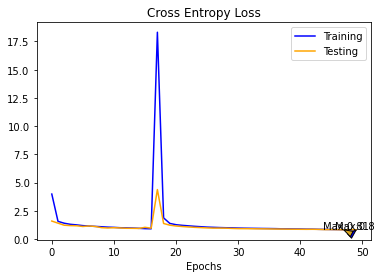

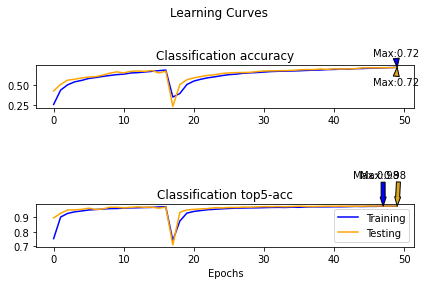

In [31]:
curves(tested_history)

## 1B

In [32]:
path = 'Results_Article/1B'
total_acc = list()
num_blocks = 32
for i in range(0,num_blocks):
    with open(path + '/accuracy_Blocks_'+ str(num_blocks) + '_L' + str(i+1) +'.pkl','rb') as file:
        partial_acc = pickle.load(file)
        total_acc.append(partial_acc)

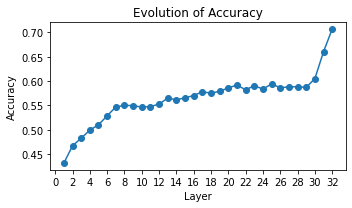

In [33]:
#Change this parameters
accuracy_evolution_tested = total_acc # the index represents the position of num_blocks
name = '_' + str(num_blocks) +'L' # num_block[1] = 12 (layers)
######################################################
block = len(accuracy_evolution_tested)
x = list(range(1,block+1))
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(x,accuracy_evolution_tested,marker='o')
ax.set_xlabel('Layer')
ax.set_ylabel('Accuracy')
plt.locator_params(axis='x', nbins=block)
plt.title('Evolution of Accuracy')
plt.tight_layout()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.savefig('Results_Article/1B/EvolutionAcc_' + name +'.png') 
plt.show()
